## Loading up the cleaned database and import libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer, StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.dummy import DummyRegressor 
#instead of manually imputing a col with the mean SalePrice for the baseline model and then 
# dropping the col, we'll be using sklearn's DummyRegressor for this



Bad key "text.kerning_factor" on line 4 in
/Users/prakky/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
new_train = pd.read_csv('../datasets/cleaned_train.csv')
new_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049 entries, 0 to 2048
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Overall Qual          2049 non-null   int64  
 1   Overall Cond          2049 non-null   int64  
 2   Year Built            2049 non-null   int64  
 3   Total Bsmt SF         2049 non-null   float64
 4   Gr Liv Area           2049 non-null   int64  
 5   Full Bath             2049 non-null   int64  
 6   TotRms AbvGrd         2049 non-null   int64  
 7   Garage Yr Blt         2049 non-null   float64
 8   Garage Area           2049 non-null   float64
 9   SalePrice             2049 non-null   int64  
 10  Has_remod             2049 non-null   int64  
 11  External_SF           2049 non-null   int64  
 12  Lot Shape             2049 non-null   int64  
 13  Garage Finish         2049 non-null   float64
 14  Exter Qual            2049 non-null   int64  
 15  Electrical           

In [3]:
# Preprocessing: Turn Train/test split & StandardScaler into a function


cols_to_remove = ['SalePrice']

features = [col for col in new_train.columns if col not in cols_to_remove]
X = new_train[features]
y = new_train['SalePrice']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
print("Shape of X_train:",X_train.shape,"\nShape of X_test:", X_test.shape )

# Scale the independant feature cols
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)


Shape of X_train: (1639, 44) 
Shape of X_test: (410, 44)


## Modeling

There are 2 methods in validating our model, but as the test set does not have the target variable, we would split the train data and cross validate to evaluate our model.

**Regression Models used in order:** Linear --> Ridge --> Lasso --> ElasticNet

**Metrics used:** Adj. R2 Score and RMSE

As we are evaluting several independant variables, our R2 score becomes less important and we'll be using the adjusted R2 score instead. This gives a better sense of the prediction once we start changing the number of independant features. RMSE is a good measure of how accurately the model predicts the response, and we'll be coupling it with the Adj R2 to better evaluate the regression models.

In [4]:
# Establish baseline scores using the mean of SalePrice

dummy_mean = DummyRegressor(strategy='mean')
dummy_mean.fit(X_train_scaled, y_train)
dummy_mean.score(X_test_scaled, y_test) 

-0.0016366504634801604

**Great, our baseline is very close to zero!** 

Let's proceed with the rest of the models and aim for a higher score.

In [5]:
# using LinearRegression we find the optimal value for k-fold

for folds in range(5,21,2):
    print ('------------------------------------\n')
    print ('K:', folds)
    model = LinearRegression()
    
    model.fit(X_train_scaled,y_train)

    # Print out only train scores (cross val)
    model_cv_scores = cross_val_score(model, X_train_scaled,y_train, cv=folds)
    adj_r2_train = 1 - (1 - model_cv_scores.mean()) * ((X_train_scaled.shape[0] - 1) / (X_train_scaled.shape[0] - X_train_scaled.shape[1] - 1))
    print("Adj R2 Score of Cross_val Train:",adj_r2_train)
    model_cv_mse_scores = -cross_val_score(model,X_train_scaled,y_train,scoring ='neg_mean_squared_error', cv=folds)
    print("RMSE of Cross_val train_set:",np.sqrt(model_cv_mse_scores.mean()))


------------------------------------

K: 5
Adj R2 Score of Cross_val Train: 0.8371858816370833
RMSE of Cross_val train_set: 31330.883576332588
------------------------------------

K: 7
Adj R2 Score of Cross_val Train: 0.7969430636283689
RMSE of Cross_val train_set: 34467.72500843838
------------------------------------

K: 9
Adj R2 Score of Cross_val Train: 0.737372169966569
RMSE of Cross_val train_set: 39197.90389906244
------------------------------------

K: 11
Adj R2 Score of Cross_val Train: 0.7858543681856802
RMSE of Cross_val train_set: 35125.50482070632
------------------------------------

K: 13
Adj R2 Score of Cross_val Train: 0.8429625610560814
RMSE of Cross_val train_set: 30697.949807969067
------------------------------------

K: 15
Adj R2 Score of Cross_val Train: 0.8197656424343169
RMSE of Cross_val train_set: 31957.65718405821
------------------------------------

K: 17
Adj R2 Score of Cross_val Train: 0.7680123102515919
RMSE of Cross_val train_set: 36212.078148801236


#### It seems that k=13 is the optimal no. of folds for our cross val prediction

In [6]:
# Default model hyperparameters, before any customisation

model_dict_old = {
'Linear': LinearRegression(),
'Ridge': RidgeCV(),
'Lasso': LassoCV(),
'ElasticNet': ElasticNetCV()
}

In [7]:
# Creating a function that we can use for future models

def regression_model(model_name, model_dict):

    global X_train_scaled, X_test_scaled, y_train, y_test, features
    
    model = model_dict[model_name]
    
    model.fit(X_train_scaled,y_train)

    # Print out train scores (cross val)
    model_cv_scores = cross_val_score(model, X_train_scaled,y_train, cv=13)
    adj_r2_train = 1 - (1 - model_cv_scores.mean()) * ((X_train_scaled.shape[0] - 1) / (X_train_scaled.shape[0] - X_train_scaled.shape[1] - 1))
    print("Adj R2 Score of Cross_val Train:",adj_r2_train)
    model_cv_mse_scores = -cross_val_score(model,X_train_scaled,y_train,scoring ='neg_mean_squared_error', cv=13)
    print("RMSE of Cross_val train_set:",np.sqrt(model_cv_mse_scores.mean()))

    # Print out test scores (no cross val)
    test_r2 = model.score(X_test_scaled,y_test)
    adj_r2_test = 1 - (1 - test_r2) * ((X_train_scaled.shape[0] - 1) / (X_train_scaled.shape[0] - X_train_scaled.shape[1] - 1))
    print("\nAdj R2 Score of Validation:",adj_r2_test)
    RMSE_test = np.sqrt(mean_squared_error(y_test,model.predict(X_test_scaled)))
    print("RMSE of Validation_set:", RMSE_test)

    # Plot the feature coeff for that model  
    plt.title(model_name+" Regression feature coeffcients", fontsize=20)
    pd.Series(model.coef_, index=features).plot.bar(figsize=(15,7), color=np.random.choice(['#5FC0B6','#D1945E','#206622','#32B9FA','#BE26F4']));
    
# Color palette for the visualisation was chosen from Adobe Color to be Color Blind Safe

**Let's start fitting our models**

Starting with a basic Linear Regression model...

Adj R2 Score of Cross_val Train: 0.8429625610560814
RMSE of Cross_val train_set: 30697.949807969067

Adj R2 Score of Validation: 0.8692009005376484
RMSE of Validation_set: 27554.621793859587


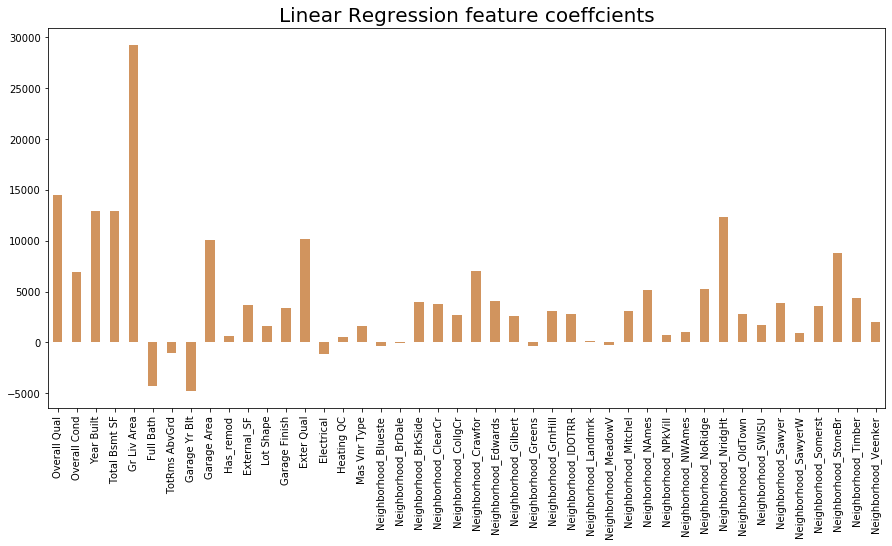

In [8]:
regression_model('Linear', model_dict_old)

#### Fit Lasso/Ridge/ElasticNet models with default parameters and optimised k-fold parameters

Adj R2 Score of Cross_val Train: 0.8569942543322846
RMSE of Cross_val train_set: 29535.348596242635

Adj R2 Score of Validation: 0.8687482745308822
RMSE of Validation_set: 27602.256553679577


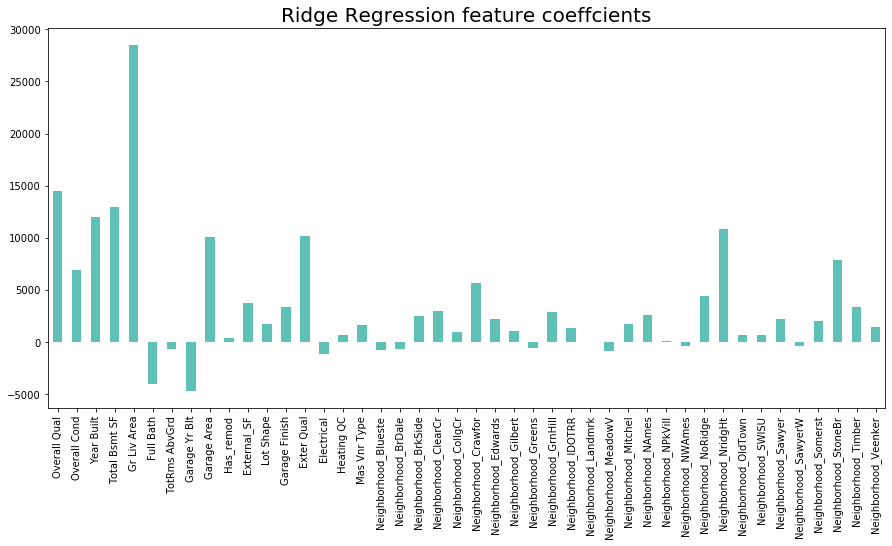

In [9]:
regression_model('Ridge', model_dict_old)

Adj R2 Score of Cross_val Train: 0.8569914913824063
RMSE of Cross_val train_set: 29536.702928857798

Adj R2 Score of Validation: 0.8677000336972034
RMSE of Validation_set: 27712.259953437755


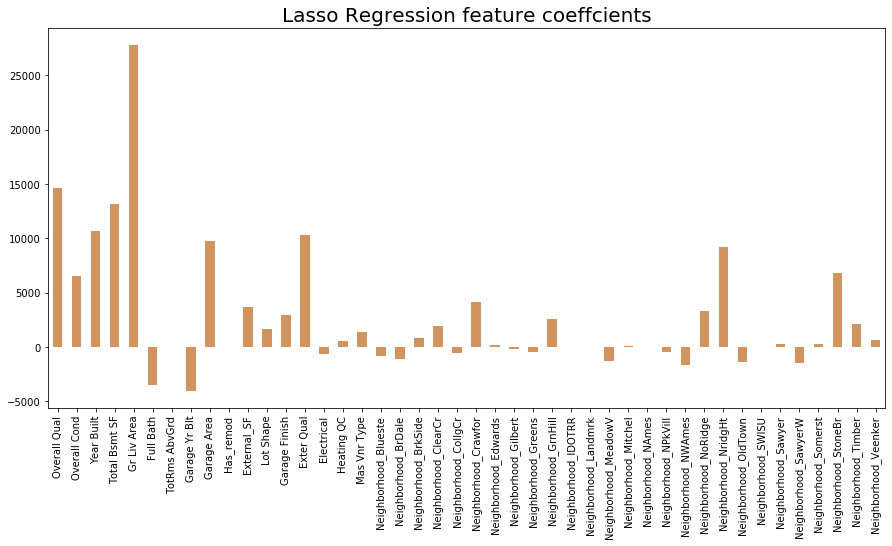

In [10]:
regression_model('Lasso',model_dict_old)

Adj R2 Score of Cross_val Train: 0.10641474067615586
RMSE of Cross_val train_set: 74026.50887986248

Adj R2 Score of Validation: 0.1132540929430228
RMSE of Validation_set: 71745.00558545184


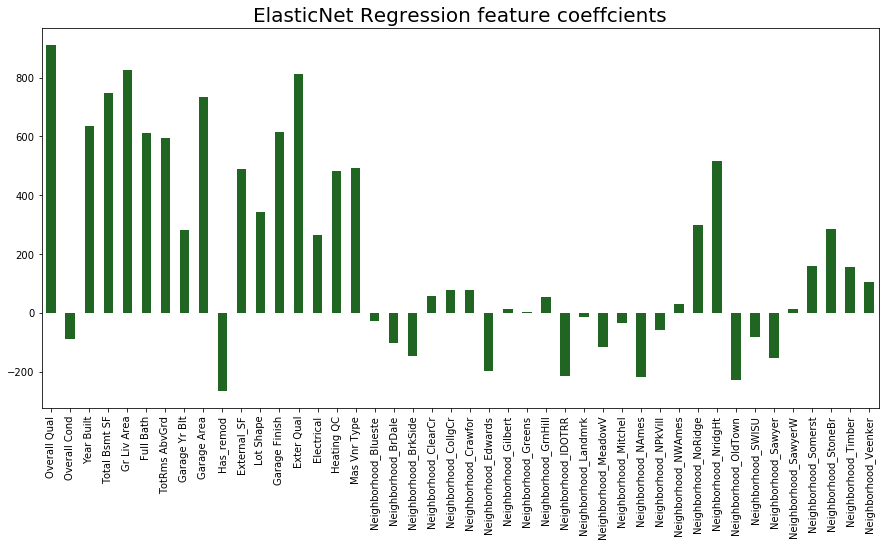

In [11]:
regression_model('ElasticNet', model_dict_old)

### Observations:

1. The best model with a high adj R2 score and lowest RMSE is : **Ridge**
2. The feature 'Gr_Liv_Area' shows signifcant multicollinearity and will be removed
3. Our ElasticNet model performed rather poor on default parameters, we shall observe if this changes after tuning the parameters
4. Based on the Lasso regularisation, we would be removing several features with coef closer to 0 (which includes a number of neighbourhoods) and rerun the model

In [12]:
# 1st run
cols_to_remove = ['SalePrice','Gr_liv_area','Neighborhood_CollgCr', 'Neighborhood_Gilbert',
                  'Neighborhood_IDOTRR', 'Neighborhood_Landmrk',
                  'Neighborhood_NAmes', 'Neighborhood_SWISU',  
                  'Neighborhood_MeadowV','Neighborhood_Mitchel',
                  'Neighborhood_Sawyer','Neighborhood_SawyerW', 'Neighborhood_SWISU']


features = [col for col in new_train.columns if col not in cols_to_remove ]
X = new_train[features]
y = new_train['SalePrice']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
print("Shape of X_train:",X_train.shape,"\nShape of X_test:", X_test.shape )

# Scale the independant feature cols
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

Shape of X_train: (1639, 34) 
Shape of X_test: (410, 34)


Adj R2 Score of Cross_val Train: 0.8578095811262904
RMSE of Cross_val train_set: 29542.869946336912

Adj R2 Score of Validation: 0.8700434649304689
RMSE of Validation_set: 27551.74832525895


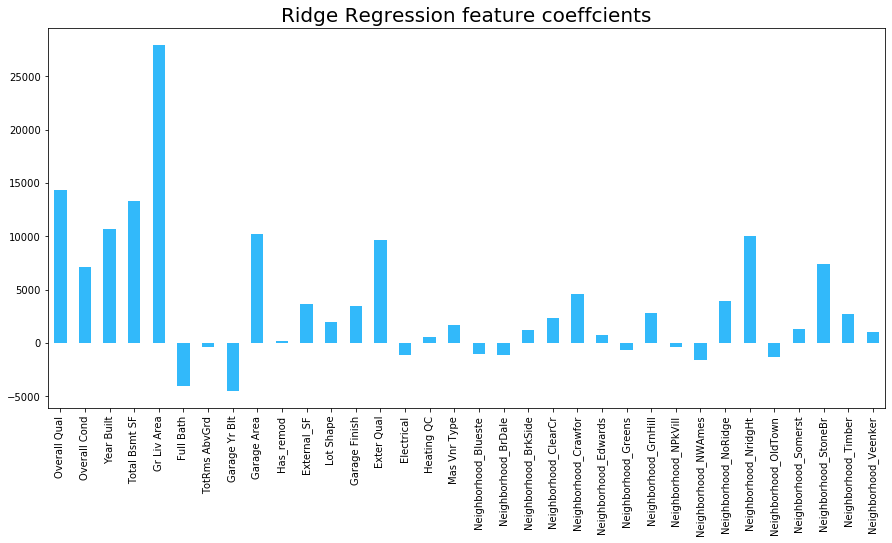

In [13]:
regression_model('Ridge', model_dict_old)

Adj R2 Score of Cross_val Train: 0.8576621120530077
RMSE of Cross_val train_set: 29557.230490007783

Adj R2 Score of Validation: 0.8695738392458735
RMSE of Validation_set: 27601.485494183096


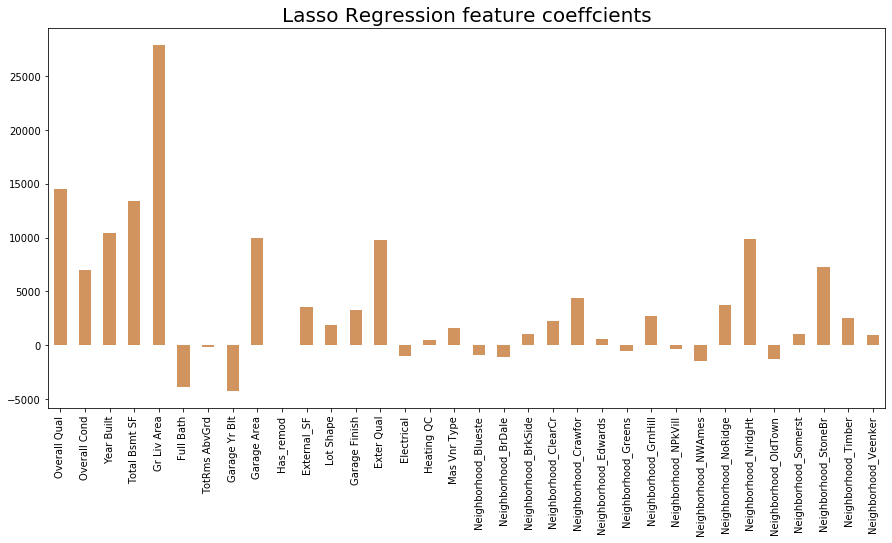

In [14]:
regression_model('Lasso', model_dict_old)

##### It seems that dropping the features did improve the overall prediction for both Lasso and Ridge, but we can still see some low coefficients. We'll proceed to remove a few more features to observe the effect.

In [15]:
# 2nd run
cols_to_remove = ['SalePrice','Gr_liv_area','Has_remod','Electrical','Heating QC','Mas Vnr Type',
                  'Neighborhood_CollgCr', 'Neighborhood_Gilbert', 'TotRms AbvGrd',
                  'Neighborhood_IDOTRR', 'Neighborhood_Landmrk','Neighborhood_Blueste','Neighborhood_BrDale',
                  'Neighborhood_NAmes', 'Neighborhood_SWISU', 'Neighborhood_OldTown', 
                  'Neighborhood_MeadowV','Neighborhood_Mitchel','Neighborhood_Greens', 'Neighborhood_NPkVill',
                  'Neighborhood_Sawyer','Neighborhood_SawyerW', 'Neighborhood_SWISU','Neighborhood_NWAmes'
                 ]

features = [col for col in new_train.columns if col not in cols_to_remove ]
X = new_train[features]
y = new_train['SalePrice']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
print("Shape of X_train:",X_train.shape,"\nShape of X_test:", X_test.shape )

# Scale the independant feature cols
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

Shape of X_train: (1639, 23) 
Shape of X_test: (410, 23)


Adj R2 Score of Cross_val Train: 0.858155350783203
RMSE of Cross_val train_set: 29598.50219159312

Adj R2 Score of Validation: 0.8698870348590471
RMSE of Validation_set: 27662.693785191183


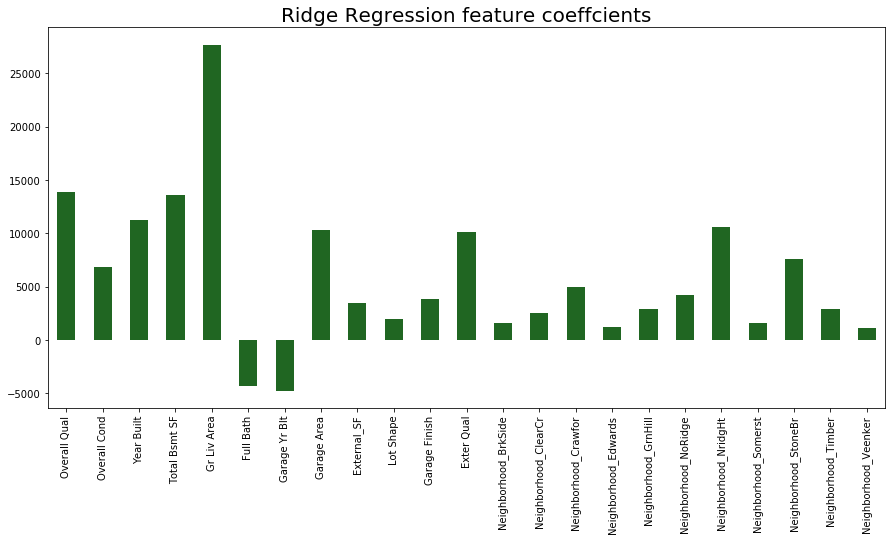

In [16]:
regression_model('Ridge', model_dict_old)

Adj R2 Score of Cross_val Train: 0.8580271126263149
RMSE of Cross_val train_set: 29612.156668510863

Adj R2 Score of Validation: 0.8697846491619197
RMSE of Validation_set: 27673.57551103439


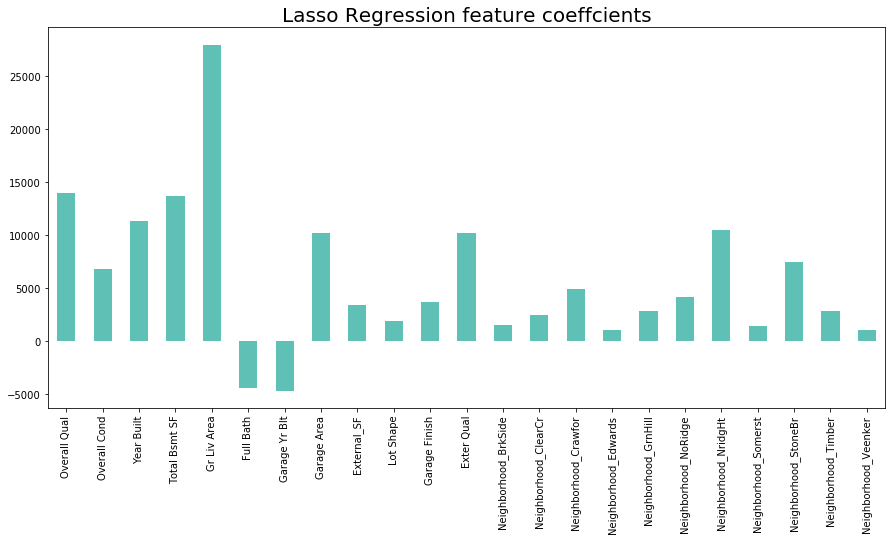

In [17]:
regression_model('Lasso', model_dict_old)

##### The models have now decreased in performance and we can observe that there are several low coefficients still remaining from the neighbourhood feature.

This could be possibly due to the one-hot encoding process inducing a lack of observations, while running through each cross validation fold. Since CV splits up the dataset into a number of folds and runs the preprocessing pipeline separately for each fold, it is possible that the training dataset used in one or more of the CV folds may not include every possible value. 

As such, we'll remove all the neighbourhood encoded features.


****

In [18]:
# 3rd run
cols_to_remove = ['SalePrice', 'Has_remod','TotRms AbvGrd',
'Neighborhood_Blueste', 
'Neighborhood_BrDale', 
'Neighborhood_BrkSide',
'Neighborhood_ClearCr',
'Neighborhood_CollgCr',
'Neighborhood_Crawfor',
'Neighborhood_Edwards',
'Neighborhood_Gilbert',
'Neighborhood_Greens',
'Neighborhood_GrnHill',
'Neighborhood_IDOTRR',
'Neighborhood_Landmrk',
'Neighborhood_MeadowV',
'Neighborhood_Mitchel',
'Neighborhood_NAmes',
'Neighborhood_NPkVill',
'Neighborhood_NWAmes',
'Neighborhood_NoRidge',
'Neighborhood_NridgHt',
'Neighborhood_OldTown',
'Neighborhood_SWISU',
'Neighborhood_Sawyer',
'Neighborhood_SawyerW',
'Neighborhood_Somerst' ,   
'Neighborhood_StoneBr',  
'Neighborhood_Timber',
'Neighborhood_Veenker']


features = [col for col in new_train.columns if col not in cols_to_remove ]
X = new_train[features]
y = new_train['SalePrice']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
print("Shape of X_train:",X_train.shape,"\nShape of X_test:", X_test.shape )

# Scale the independant feature cols
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

Shape of X_train: (1639, 15) 
Shape of X_test: (410, 15)


Adj R2 Score of Cross_val Train: 0.8435129968760178
RMSE of Cross_val train_set: 31181.34560577208

Adj R2 Score of Validation: 0.8507141233105784
RMSE of Validation_set: 29704.109711295343


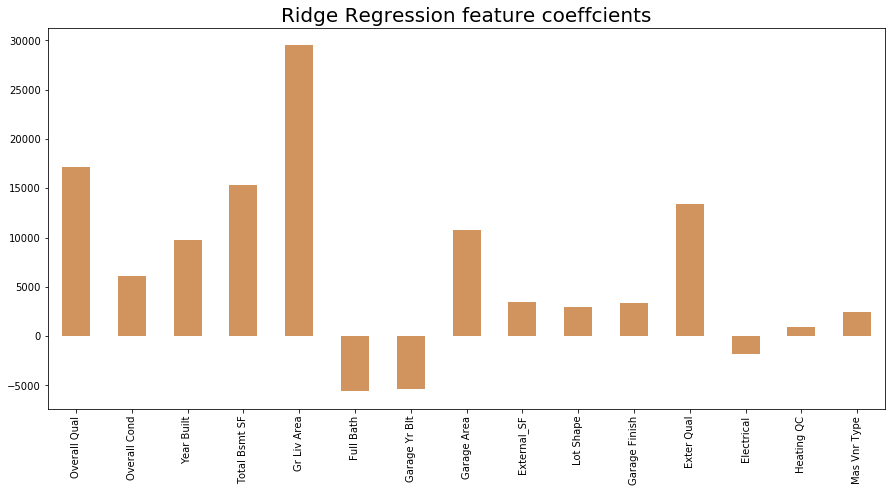

In [19]:
regression_model('Ridge', model_dict_old)

Adj R2 Score of Cross_val Train: 0.8434637310224748
RMSE of Cross_val train_set: 31185.606940362864

Adj R2 Score of Validation: 0.8505736914107302
RMSE of Validation_set: 29718.077623441015


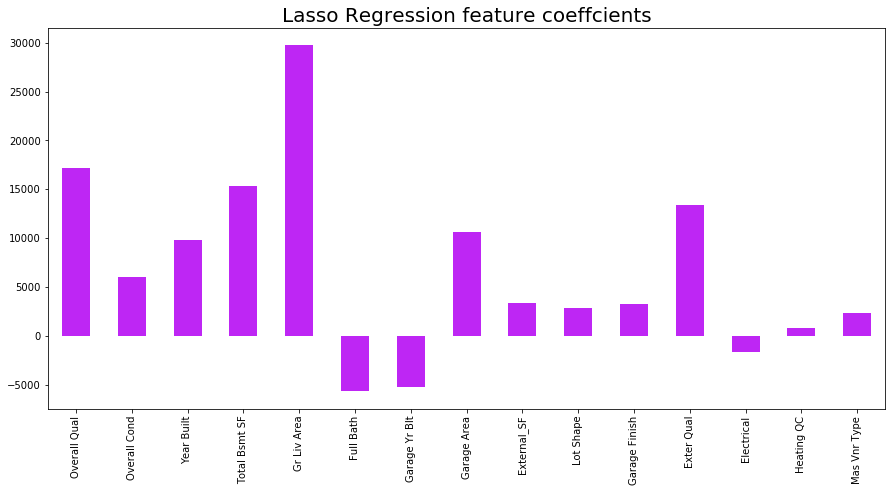

In [20]:
regression_model('Lasso', model_dict_old)

**The models continue to deteriorate in performance!**

As observed during the EDA process, most of these features don't show a linear relationship with regards to SalePrice. As such, we'll proceed to increase the order of the features by creating interaction terms to improve the models' performance.

We should also take a look at tuning the model hyperparameters from its default values but all in all, these would be the top 15 features we'll be utilising for the model.

****


### The effect of using polynomial features 

In [105]:
poly = PolynomialFeatures(include_bias=False, interaction_only=False)
X_poly = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2,random_state=42)
print("Shape of X_train:",X_train.shape,"\nShape of X_test:", X_test.shape )
features = poly.get_feature_names(features)


# Scale the independant feature cols
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

Shape of X_train: (1639, 135) 
Shape of X_test: (410, 135)


In [106]:
# New model hyperparameters and rerun the models

model_dict_new = {
'Ridge': RidgeCV(alphas=np.logspace(1, 20, 500), cv=13),
'Lasso': LassoCV(n_alphas=100, max_iter=12000, cv=13),
}

Adj R2 Score of Cross_val Train: 0.8829757129400438
RMSE of Cross_val train_set: 25891.147400628877

Adj R2 Score of Validation: 0.8950070589400081
RMSE of Validation_set: 23972.17612816138


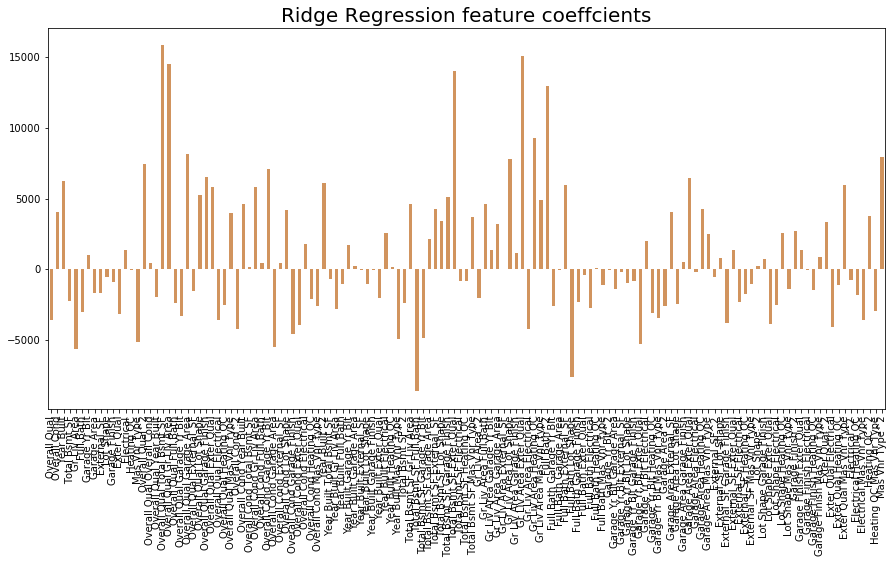

In [107]:
regression_model('Ridge', model_dict_new)

Adj R2 Score of Cross_val Train: 0.8832912695978429
RMSE of Cross_val train_set: 25859.329069887088

Adj R2 Score of Validation: 0.894542823437901
RMSE of Validation_set: 24025.11521416528


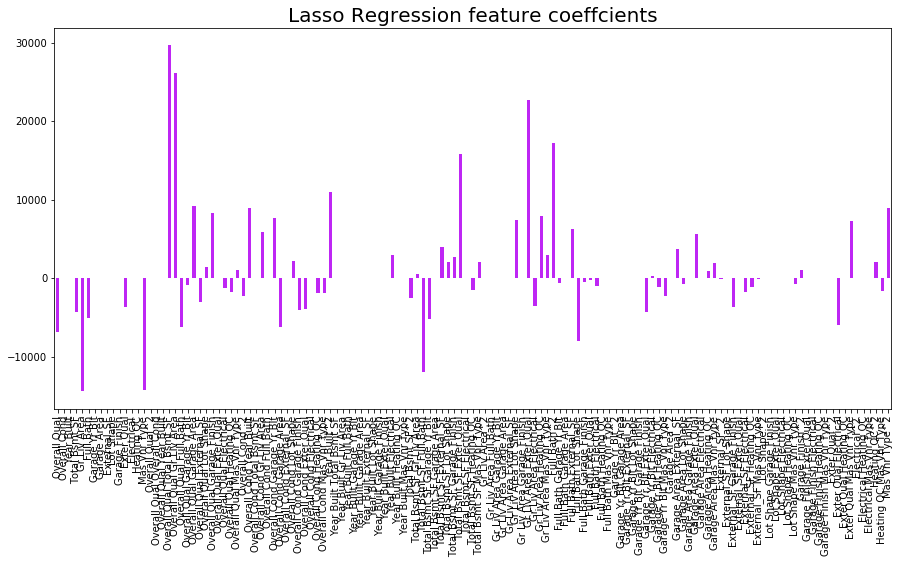

In [97]:
regression_model('Lasso', model_dict_new)

### Tremendous improvement in the models, specifically our Ridge model

This means that interaction terms did definitely help. By adding new variables that represent the interaction between features, e.g a new column that represents one variable multiplied by itself, as well as creating a new “interaction” variable for each pair of input variables.

These additional input variables will change the probability distribution, separating the small and large values, a separation that is increased with the size of the exponent, improving the fit of the model.

*****


## Production model
- Let's bring in the kaggle test data and transform it to match the new_train dataset

In [25]:
kaggle = pd.read_csv('../datasets/test.csv')
drop_cols = [x for x in kaggle.columns if x not in new_train.columns]
drop_cols = [x for x in drop_cols if x not in ['Id','Year Remod/Add','Wood Deck SF','Open Porch SF']]

In [26]:
kaggle.drop(columns=drop_cols, axis=1, inplace=True)
kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              879 non-null    int64  
 1   Lot Shape       879 non-null    object 
 2   Overall Qual    879 non-null    int64  
 3   Overall Cond    879 non-null    int64  
 4   Year Built      879 non-null    int64  
 5   Year Remod/Add  879 non-null    int64  
 6   Mas Vnr Type    878 non-null    object 
 7   Exter Qual      879 non-null    object 
 8   Total Bsmt SF   879 non-null    int64  
 9   Heating QC      879 non-null    object 
 10  Electrical      878 non-null    object 
 11  Gr Liv Area     879 non-null    int64  
 12  Full Bath       879 non-null    int64  
 13  TotRms AbvGrd   879 non-null    int64  
 14  Garage Yr Blt   834 non-null    float64
 15  Garage Finish   834 non-null    object 
 16  Garage Area     879 non-null    int64  
 17  Wood Deck SF    879 non-null    int

In [27]:
# find diff between remod and yr built and label 1 and 0 and rename column
kaggle['Has_remod'] = kaggle['Year Remod/Add'] - kaggle['Year Built']
kaggle.has_remod = kaggle['Has_remod'].apply(lambda val: 1 if val != 0 else val)
kaggle['External_SF'] = kaggle['Wood Deck SF'] + kaggle['Open Porch SF']

/Users/prakky/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
# drop cols : 'Year Remod/Add' , 'Wood Deck SF' , 'Open Porch SF'
kaggle.drop(columns=['Year Remod/Add','Wood Deck SF','Open Porch SF'], axis=1, inplace=True)

In [29]:
#Label Encode the 6 categorical cols
# Coupled with external research and using some basic common sense, these features can be 
# turned ordinal based on their intrinsic characteristics

kaggle['new_Lot Shape'] = kaggle['Lot Shape'].map({'Reg':1,'IR3':2,'IR1':3,'IR2':4})
kaggle['new_Garage Finish'] = kaggle['Garage Finish'].map({'Unf':1,'RFn':2,'Fin':3, 0:0})
kaggle['new_Exter Qual'] = kaggle['Exter Qual'].map({'TA':2,'Gd':3,'Ex':4, 'Fa':1})
kaggle['new_Electrical'] = kaggle['Electrical'].map({'SBrkr':5,'FuseA':4,'FuseF':3, 'FuseP':2, 'Mix':1})
kaggle['new_Heating QC'] = kaggle['Heating QC'].map({'TA':3,'Gd':4,'Ex':5,'FA':2,'Po':1})
kaggle['new_Mas Vnr Type'] = kaggle['Mas Vnr Type'].map({'Stone':4,'BrkFace':3,'BrkCmn':2, 'None':0})

In [30]:
# dropped the original cols and renamed the new feature cols
kaggle.drop(columns=['Lot Shape','Garage Finish','Exter Qual','Electrical','Mas Vnr Type','Heating QC','Has_remod', 'TotRms AbvGrd'], axis=1, inplace=True)
kaggle.columns = [col.replace('new_','') for col in kaggle.columns]

In [31]:
kaggle.fillna(0,inplace=True)
kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             879 non-null    int64  
 1   Overall Qual   879 non-null    int64  
 2   Overall Cond   879 non-null    int64  
 3   Year Built     879 non-null    int64  
 4   Total Bsmt SF  879 non-null    int64  
 5   Gr Liv Area    879 non-null    int64  
 6   Full Bath      879 non-null    int64  
 7   Garage Yr Blt  879 non-null    float64
 8   Garage Area    879 non-null    int64  
 9   External_SF    879 non-null    int64  
 10  Lot Shape      879 non-null    int64  
 11  Garage Finish  879 non-null    float64
 12  Exter Qual     879 non-null    int64  
 13  Electrical     879 non-null    float64
 14  Heating QC     879 non-null    float64
 15  Mas Vnr Type   879 non-null    float64
dtypes: float64(5), int64(11)
memory usage: 110.0 KB


### Kaggle test dataset has been cleaned, let's polytransform the features and run it through both models

In [74]:
X_kaggle = kaggle[[col for col in kaggle.columns if col != 'Id']]
X_poly_kaggle = poly.fit_transform(X_kaggle)
X_poly_kaggle.shape

(879, 135)

**Let's instantiate and fit the ridge model**

We'll manually tweak the hyperparameters slightly to accomodate a larger train dataset

In [98]:
ridge = RidgeCV(alphas=np.logspace(1, 20, 1000), cv=9)

**R2 score of Lasso on kaggle blind data**

In [100]:
ridge.fit(X_poly,y)
print("R2 score:",ridge.score(X_poly, y))
print()
print("RMSE:", np.sqrt(mean_squared_error(y,ridge.predict(X_poly))))

R2 score: 0.9066497483733127

RMSE: 24221.58443120137


In [35]:
preds = ridge.predict(X_poly_kaggle)

In [36]:
kaggle_subm4 = kaggle.copy()
kaggle_subm4['SalePrice'] = preds
kaggle_subm4.drop(columns=[col for col in kaggle.columns if col not in ['Id', 'SalePrice']], axis=1, inplace=True)

In [37]:
#output the submission file
kaggle_subm4.to_csv('../datasets/kaggle_subm4.csv', index=False)

**Let's instantiate and fit the lasso model**

We'll manually tweak the hyperparameters slightly to accomodate a larger train dataset

**R2 score of Lasso on kaggle blind data**

In [101]:
lasso = LassoCV(n_alphas=100, max_iter=9000, cv=13)
lasso.fit(X_poly,y)
print("R2 score:",lasso.score(X_poly,y))
print()
print("RMSE:", np.sqrt(mean_squared_error(y,lasso.predict(X_poly))))

R2 score: 0.8208001196341924

RMSE: 33559.359225011955


In [76]:
preds2 = lasso.predict(X_poly_kaggle)

In [77]:
kaggle_subm5 = kaggle.copy()
kaggle_subm5['SalePrice'] = preds2
kaggle_subm5.drop(columns=[col for col in kaggle.columns if col not in ['Id', 'SalePrice']], axis=1, inplace=True)

In [78]:
#output the submission file
kaggle_subm5.to_csv('../datasets/kaggle_subm5.csv', index=False)

### Final Kaggle submission using Ridge model

![image](../datasets/kaggle_score.png)

## Conclusion:

The more obvious inferences like having a better overall quality or a bigger size having a direct impact to the sale price. However, some interesting features were discovered to add more value to the overall value. For example, having the presence of a paved driveway, using poured concrete for your foundation or having a hipped roof, is a type of roof where all sides slope downwards to the walls.

Features like having an unfinished garage interior, having a knob & tube wiring fusebox or having a carport(basically an unenclosed garage with 2 open sides) will hurt the sale value of a home.

If customers were interested in flipping houses (buying reasonably priced homes and refurnishing them), the neighbourhoods of **Northridge Heights and Stone Brook** would be of interest to potential 'investors'.

On top of this, we have built a SalePrice estimator, which at the moment has a standard deviation of approximately  **$26k** (tested against blind data) which has to be informed to the consumer.
